In [63]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cvxpy as cp
from copy import copy
from carbon import ConstantProductCurve as CPC, CPCContainer
from carbon.helpers.version import require_version
require_version("1.1.1", CPCContainer.__VERSION__)
plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize'] = [12,6]

# Multi Asset Routing [NB01]

This code is inspired by the paper and code from "Optimal Routing for Constant Function Market Makers" (Angeris et al 2022) [[arxiv][arx], [code][pcode]]. It requires [`cvxpy`][cvxpy] which is not a standard install on Conda, but can be installed using `pip`. This notebook also requires the `carbon` library from the [Carbon Simulator][sim] available for import.

[sim]:https://github.com/bancorprotocol/carbon-simulator
[cvxpy]:https://www.cvxpy.org/install/index.html
[arx]:https://arxiv.org/pdf/2204.05238v1.pdf
[pcode]:https://math.paperswithcode.com/paper/optimal-routing-for-constant-function-market

## Scenario

Here we create the a randomized market scenario. The keys of the `prices` dict are the tokens in the system, and the value is the price in an arbitrary numeraire. We recommend that one of the tokens is the cash token, and that therefore its price is one, but this is not necessary. The constant `N` determines how many curves are generated _per pair_, and the `_rg` determine the random parameters, as detailed in the comments below.

In [64]:
prices = dict(
    USDC=1,
    LINK=5,
    ETH=2000,
    WBTC=20000,
)
N = 4        # number of curves per pool
krg = 2      # pool constant k; eg 2 = 0.5 .. 2x
prg = 0.2    # price; eg 0.2 = plus/minus 20%
wrg = 0.2    # price range width; eg 0.2 = plus/minus 20%

In [65]:
CC = CPCContainer()
for tkn1, ptkn1 in prices.items():
    for tkn2, ptkn2 in prices.items():
        if ptkn1 >= ptkn2 and tkn1 != tkn2:
            pair = f"{tkn1}/{tkn2}"
            ptkn12 = ptkn1/ptkn2
            print(f"{pair}: {ptkn12}")
            for i in range(N):
                price = ptkn12*CC.u(1-prg, 1+prg)
                k = 10000**2/ptkn1/ptkn2*CC.u(1/krg, krg)
                CC += CPC.from_pkpp(p=price, k=k, p_min=price*CC.u(1-wrg, 0.99), p_max=price*CC.u(1.01, 1+wrg), pair=pair)

LINK/USDC: 5.0
ETH/USDC: 2000.0
ETH/LINK: 400.0
WBTC/USDC: 20000.0
WBTC/LINK: 4000.0
WBTC/ETH: 10.0


The `tokentable` shows to which curves a given token is the `x` and `y` token respectively.

In [66]:
CC.tokentable

{'USDC': {'x': [], 'y': [0, 1, 2, 3, 4, 5, 6, 7, 12, 13, 14, 15]},
 'WBTC': {'x': [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], 'y': []},
 'ETH': {'x': [4, 5, 6, 7, 8, 9, 10, 11], 'y': [20, 21, 22, 23]},
 'LINK': {'x': [0, 1, 2, 3], 'y': [8, 9, 10, 11, 16, 17, 18, 19]}}

Here we generate the charts. The thin dotted line is the unconstraint curve, the thick grey line is taking the curve leverage (number of tokens available) into account. The `*` marker indicates the current virtual state of the curve.

pair = WBTC/USDC


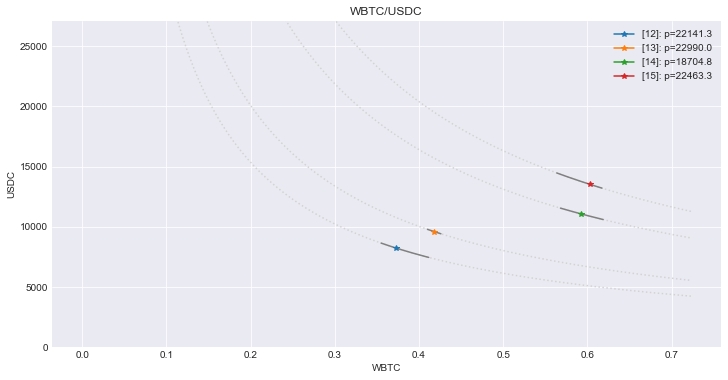

pair = ETH/USDC


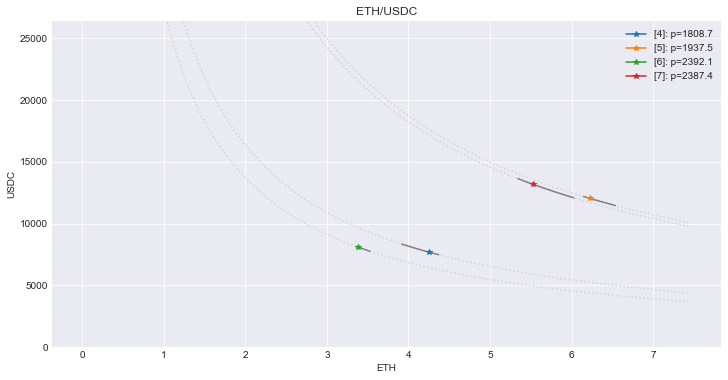

pair = ETH/LINK


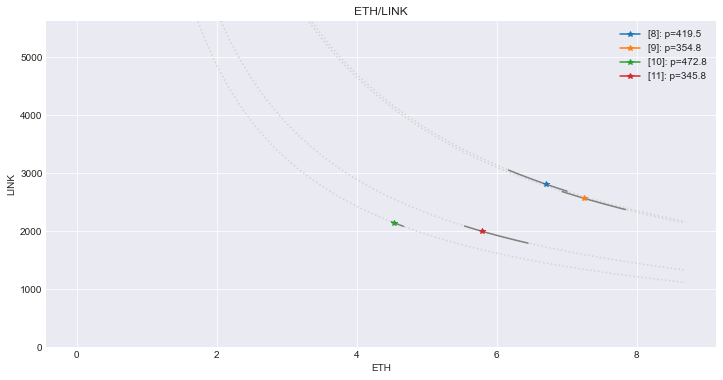

pair = WBTC/LINK


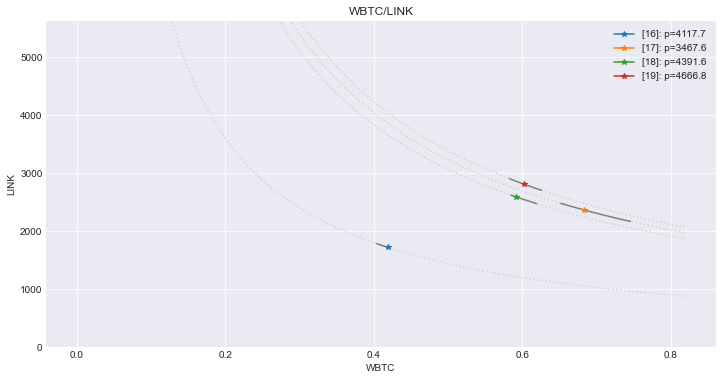

pair = LINK/USDC


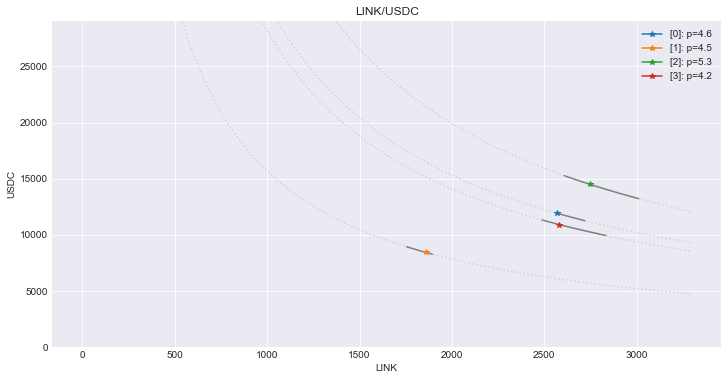

pair = WBTC/ETH


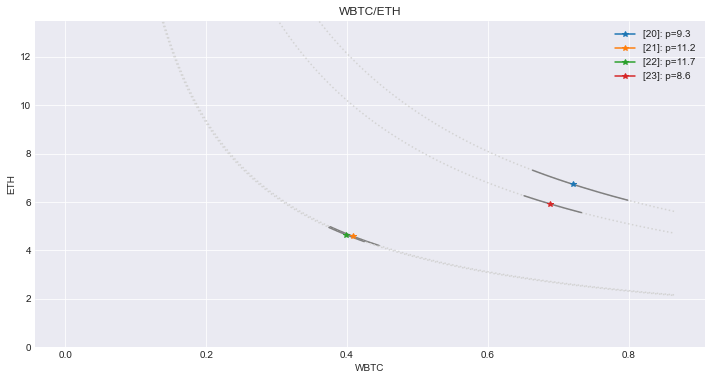

In [67]:
eps=1e-10
for pair in CC.pairs:
    print(f"pair = {pair}")
    curves = CC.bypair(pair)
    statx, staty = CC.xystats(curves)
    xr = np.linspace(0+eps,statx.maxv*1.2,500)
    for i, c in enumerate(curves):
        plt.plot(xr, [c.yfromx_f(x_, ignorebounds=True) for x_ in xr], color="lightgrey", linestyle="dotted")
        plt.plot(xr, [c.yfromx_f(x_) for x_ in xr], color="grey")
    
    for c in curves:
        plt.plot(c.x, c.y, marker="*", label=f"[{c.cid}]: p={c.p:.1f}")  
    
    plt.title(f"{pair}")
    plt.ylim((0, staty.maxv*2))
    plt.xlabel(f"{c.tknx}")
    plt.ylabel(f"{c.tkny}")
    plt.legend()
    plt.grid()
    plt.show()

## Inputs

Use `AMMPays` or `AMMReceives` for the token that is optimized for.

Inputs are seen from the point of view of the AMM, meaning that **positive** numbers means amounts that are **paid into the AMM** and vice versa. You can mix positive and negative numbers for inputs, but you have to be right about the direction of the resulting flow of the open token.

Note: if you have one input set to "AMMPays" and all other inputs are zero then you are looking for arbitrages.

In [68]:
inputs = dict(
    USDC = "AMMPays",    # "AMMPays" or "AMMReceives"
    ETH = 1,             # positive = AMM receives, negative = AMM pays
)

validations and summary information

In [69]:
pr = [v for v in inputs.values() if isinstance(v, str)]
assert len(pr) == 1, f"you must have EXACTLY one item with AMMPays, AMMReceives \n{inputs}"
pr = pr[0]
assert pr in {"AMMPays", "AMMReceives"},  f"indicator must be only AMMPays, AMMReceives \n{inputs}"
prtkn = [k for k,v in inputs.items() if isinstance(v, str)][0]
pm = {1 if v > 0 else -1 for v in inputs.values() if not isinstance(v, str) and v != 0}
if len(pm) == 2:
    print("Warning: mixed prices. Ensure AMMPays/AMMReceives is set correctly")
elif pm == set():
    print("No inputs found; performing arbitrage analyis. AMMPays has been selected.")
    pr = "AMMPays"
else:
    if pm == {1}:
        assert pr == "AMMPays", f"AMMPays requires at least one positive input\n{inputs}"
    else:
        assert pr == "AMMReceives", f"AMMReceives requires at least one positive input\n{inputs}"

# set non-existing items to zero        
for tkn in prices:
    if inputs.get(tkn) is None:
        inputs[tkn] = 0

print("pay/receive:        ", pr)
print("pay/receive token:  ", prtkn)
print("plus/minus/mixed:   ", pm)
print("inputs:\n ", inputs)

pay/receive:         AMMPays
pay/receive token:   USDC
plus/minus/mixed:    {1}
inputs:
  {'USDC': 'AMMPays', 'ETH': 1, 'LINK': 0, 'WBTC': 0}


## Optimization

This code runs the actual optimization. It has two major parts

1. the **constraints**, and 
2. the **objective function** to be optimized (min or max)

The objective function is to either maximize the number of tokens received from the AMM (which is a negative number, hence formally the condition is `cp.Minimize` or to minimize the number of tokens paid to the AMM which is a positive number. Therefore `cp.Minimize` is the correct choice in each case.

The constraints come in three types:

- **curve constraint**: the curve constraints correspond to the $x\cdot y=k$ invariant of the respective AMM; the constraint is formally `>=` but it has been shown eg by Angeris et al that the constraint will always be optimal on the boundary

- **range constraints**: the range constraints correspond to the tokens actually available on curve; for the full-curve AMM those constraints would formally be `dx >= -c.x` and the same for `y`, but those constraint are automatically fulfilled because of the asymptotic behaviour of the curves so could be omitted

- **self-financing constraints**: the self-financing constraints corresponds to the condition that all `dx` and `dy` corresponding to a specific token other than the token in the objective function must sum to the target amount provided in `inputs` (or zero if not provided)

In [82]:
dx = cp.Variable(len(CC))
dy = cp.Variable(len(CC))
tt = CC.tokentable

gmean = lambda lst: cp.geo_mean(cp.hstack(lst))
constraints = []

# curve constraints
for i, c in enumerate(CC):
    constraints += [gmean([c.x+dx[i], c.y+dy[i]]) >= c.kbar]
    
# leverage constraints
for i, c in enumerate(CC):
    #print(i, c.pair, c.x_act, c.y_act)
    constraints += [
        dx[i] >= -c.x_act,
        dy[i] >= -c.y_act,
    ]
    
# self-financing constraints
for tkn, tknvalue in inputs.items():
    if not isinstance(tknvalue, str):
        print(f'Constraints: y={[i for i in tt[tkn]["y"]]}, x={[i for i in tt[tkn]["x"]]}, {tkn}={tknvalue}')
        constraints += [
            sum([dy[i] for i in tt[tkn]["y"]])+sum([dx[i] for i in tt[tkn]["x"]]) == tknvalue
        ]

# objective function  (note: AMM out is negative, AMM in is positive)
print(f'Objective: y={[i for i in tt[prtkn]["y"]]}, x={[i for i in tt[prtkn]["x"]]}, {prtkn}')
        
objective = cp.Minimize(
     sum([dy[i] for i in tt[prtkn]["y"]])+sum([dx[i] for i in tt[prtkn]["x"]])
)

# run the optimization
problem = cp.Problem(objective, constraints)
result = problem.solve(verbose=False)  
print(f"r={result:.2f}")

Constraints: y=[20, 21, 22, 23], x=[4, 5, 6, 7, 8, 9, 10, 11], ETH=1
Constraints: y=[8, 9, 10, 11, 16, 17, 18, 19], x=[0, 1, 2, 3], LINK=0
Constraints: y=[], x=[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], WBTC=0
Objective: y=[0, 1, 2, 3, 4, 5, 6, 7, 12, 13, 14, 15], x=[], USDC
r=-2703.15


## Results

The `status` field shows whether the optimization succeeded. Everything else than `optimal` is, well, not optimal. The `result` field corresponds to the achieved objective function. A negative number corresponds to the AMM paying out this amount, a positive number to the AMM receiving it. The token is also provided. The `dx` and `dy` fields finally corresponds to the trade actions of the individual AMMs finally.

In [71]:
print(f"status: {problem.status}")
print(f"result: {result} {prtkn}")
print(f"dx: {dx.value} ({sum(dx.value):.2f})")
print(f"dy: {dy.value} ({sum(dy.value):.2f})")

status: optimal
result: -2703.153989757416 USDC
dx: [-1.28704811e+01 -3.61068814e+01  1.60643714e+02 -9.39686366e+01
 -3.84884224e-02  1.59348565e-01  1.56610499e-01  5.14179983e-01
  2.45724292e-01 -3.16686484e-01  1.32100470e-01 -2.62593204e-01
  2.47218718e-02  8.29114246e-03 -1.17683679e-02  1.61359683e-02
 -4.23898800e-04 -3.09596109e-02  1.87254466e-02  2.32928725e-02
 -4.30322672e-02  1.23098998e-02  2.06006914e-02 -3.78937653e-02] (18.29)
dy: [ 5.99923283e+01  1.67072195e+02 -8.02417376e+02  4.12718828e+02
  7.02513276e+01 -3.01027633e+02 -3.58066108e+02 -1.12305056e+03
 -9.94305723e+01  1.17479311e+02 -6.06888154e+01  9.51085117e+01
 -5.13291101e+02 -1.86905542e+02  2.24588061e+02 -3.53018410e+02
  1.74692012e+00  1.12453350e+02 -7.97101291e+01 -1.04656291e+02
  4.27704812e-01 -1.34041853e-01 -2.29026919e-01  3.45168250e-01] (-2720.44)


### Graphical results

The charts below corrspond to the charts above, the sole difference being the addition of the round marker indicating the new state of the AMM. In an unconstraint environment they should line up on a straight line going through the origin.

pair = WBTC/USDC


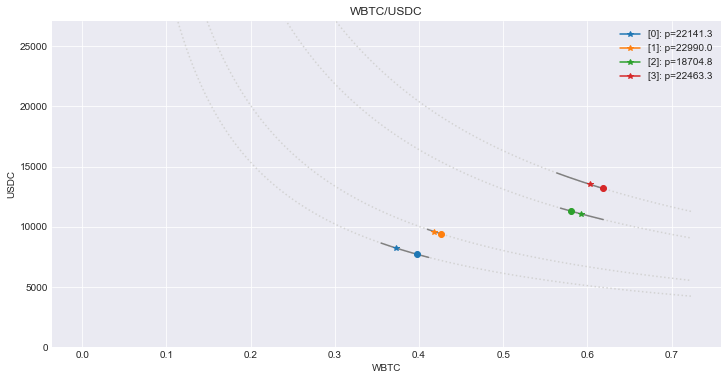

pair = ETH/USDC


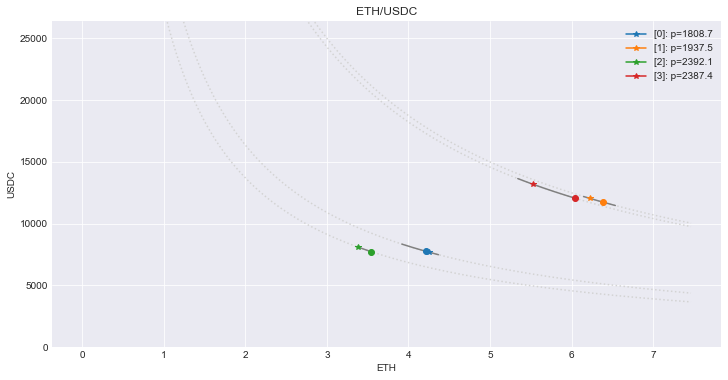

pair = ETH/LINK


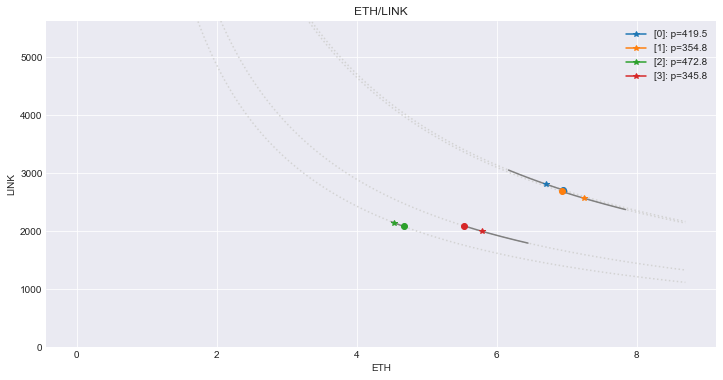

pair = WBTC/LINK


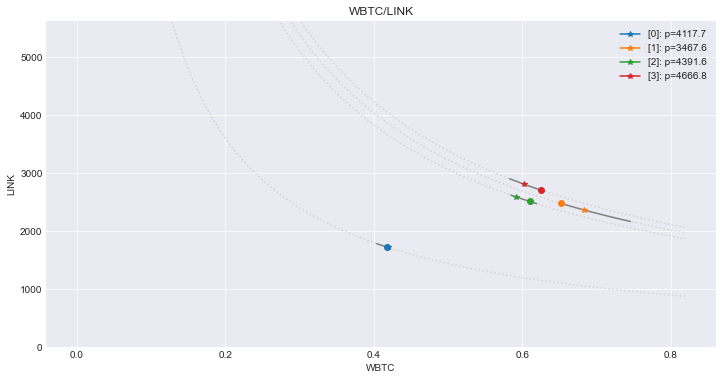

pair = LINK/USDC


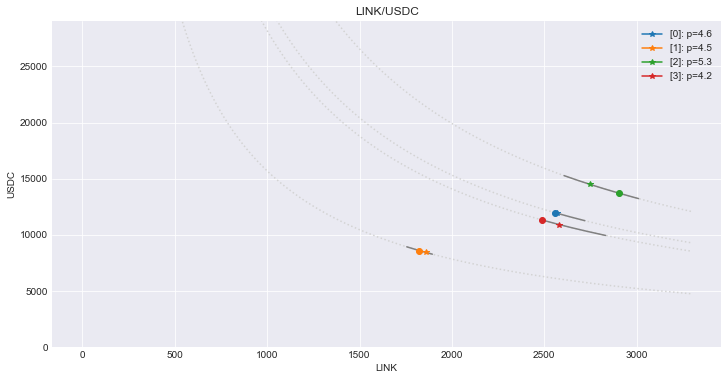

pair = WBTC/ETH


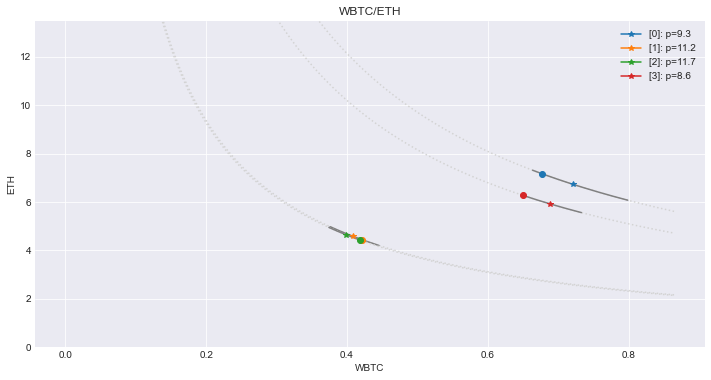

In [76]:
for pair in CC.pairs:
    print(f"pair = {pair}")
    curves = CC.bypair(pair)
    statx, staty = CC.xystats(curves)
    xr = np.linspace(0+eps, statx.maxv*1.2, 500)
    for i, c in enumerate(curves):
        plt.plot(xr, [c.yfromx_f(x_, ignorebounds=True) for x_ in xr], color="lightgrey", linestyle="dotted")
        plt.plot(xr, [c.yfromx_f(x_) for x_ in xr], color="grey")
    
    for i, c in enumerate(curves):
        plt.plot(c.x, c.y, marker="*", label=f"[{i}]: p={c.p:.1f}")
        #print(c.x)
    
    plt.gca().set_prop_cycle(None)
    for i, c in enumerate(curves):
        plt.plot(c.x+dx.value[c.cid], c.y+dy.value[c.cid], marker="o")
        #print(c.x+dx.value[c.cid], c.y+dy.value[c.cid])
    plt.title(f"{pair}")
    plt.ylim((0, staty.maxv*2))
    plt.xlabel(f"{c.tknx}")
    plt.ylabel(f"{c.tkny}")
    plt.legend()
    plt.grid()
    plt.show()

### Data

Here we provide the data in tabular form. The first table is the aggregate change in the amounts in the respective tokens.

In [73]:
dct = [
    {"cid": c.cid, "pair": c.pair, "tknx": c.tknx, "tkny": c.tkny, 
     "xa": c.x_act, "ya": c.y_act, c.tknx: dxv, c.tkny: dyv}   
    for dxv, dyv, c in zip(dx.value, dy.value, CC)
]
df = pd.DataFrame.from_dict(dct)
df = df[["cid", "pair", "xa", "tknx", "ya", "tkny"]+list(prices)].set_index("cid")
df0 = df.fillna(0)
df = df.fillna("")
dfa = pd.DataFrame(df0[list(prices)].sum(numeric_only=True)).T
dfa["cid"] = ["aggr"]
dfa = dfa.set_index("cid")
dfa

,USDC,LINK,ETH,WBTC
cid,,,,
aggr,-2703.15399,-2.401634e-11,1.0,-1.713279e-08


The second table is the result for the individual AMMs, with the summary line added to the bottom. A reminder that **positive = AMM receives** and **negative = AMM pays**.

In [74]:
df = pd.concat([df, dfa]).fillna("")
df

,pair,xa,tknx,ya,tkny,USDC,LINK,ETH,WBTC
cid,,,,,,,,,
0,LINK/USDC,12.876566,LINK,661.594658,USDC,59.992328,-12.870481,,
1,LINK/USDC,107.122611,LINK,163.131929,USDC,167.072195,-36.106881,,
2,LINK/USDC,137.767447,LINK,1289.853052,USDC,-802.417376,160.643714,,
3,LINK/USDC,93.969519,LINK,969.288713,USDC,412.718828,-93.968637,,
4,ETH/USDC,0.341339,ETH,206.742776,USDC,70.251328,,-0.038488,
5,ETH/USDC,0.072587,ETH,598.146884,USDC,-301.027633,,0.159349,
6,ETH/USDC,0.020245,ETH,358.066859,USDC,-358.066108,,0.15661,
7,ETH/USDC,0.195573,ETH,1123.052117,USDC,-1123.05056,,0.51418,
8,ETH/LINK,0.542141,ETH,126.416659,LINK,,-99.430572,0.245724,


In [83]:
from decimal import *

In [90]:
getcontext().prec = 10_000

In [92]:
Decimal(2).sqrt()

Decimal('1.414213562373095048801688724')